# Transient heat equation on hex mesh
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/solid/thermal_transient.ipynb)

Solving the transient heat eqaution on a hexahedron mesh.

In [1]:
import meshio as mo
import pyvista as pv
import torch

from torchfem import SolidHeat
from torchfem.examples import get_example_file
from torchfem.materials import IsotropicConductivity3D

from torchfem.plot_utils import emebed_pyvista_animation


# Set default data type to double precision
torch.set_default_dtype(torch.float64)


## 3D unstructured mesh with linear hexahedrons read from Abaqus input file 


In [2]:
kappa, rho, cp = 500.0, 7850.0, 500.0

In [3]:
inp_path = get_example_file("extruded_hex_mesh.inp")


# material
material = IsotropicConductivity3D(kappa=kappa, rho=rho, cp=cp)


mesh = mo.read(inp_path)
# Create model
nodes = torch.tensor(mesh.points) * 1.0e-3  # SI
elements = torch.tensor(mesh.cells_dict["hexahedron"])
box_heat = SolidHeat(nodes, elements, material)


# Assign boundary conditions
box_heat.constraints[mesh.point_sets["temp_left"]] = True
box_heat.constraints[mesh.point_sets["temp_right"]] = True
# box_heat.constraints[mesh.point_sets["insulation"]] = True
box_heat.displacements[mesh.point_sets["temp_left"], 0] = 0.0
box_heat.displacements[mesh.point_sets["temp_right"], 0] = 20.0
# box_heat.forces[nodes[:, 1] == 1.0, 0] = 0.0
# box_heat.forces[mesh.point_sets["insulation"]] = 5.0

# solver settings
end_time = 5.0
delta_t = 0.1

times = torch.tensor([0.0, end_time])

# Solve
temp, rfl, hf, temp_grad, _ = box_heat.time_integration(
    times, delta_t, verbose=False, return_intermediate=True
)


Plot the animated results.



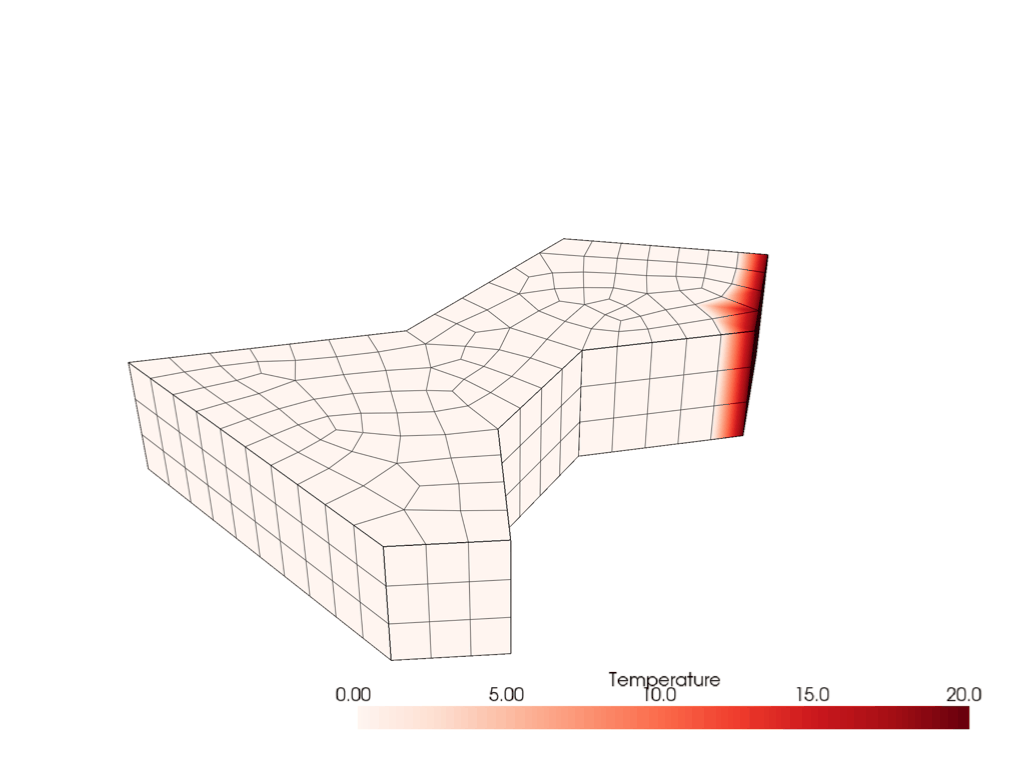

In [4]:
pl = pv.Plotter()
box_heat.plot(
    node_property={"Temperature": temp[0]},
    show_undeformed=True,
    opacity= torch.linspace(0.2, 1.0, len(temp)),
    colormap="Reds",
    clim=[temp.min(), temp.max()],
    plotter=pl,
    lighting=False,
)

# retrieve actor
for actor_key in pl.actors:
    if "UnstructuredGrid" in actor_key:
        actor = pl.actors[actor_key]

pl.add_mesh(
    actor.mapper.dataset.extract_feature_edges(),
    color="black",
    line_width=2,
    lighting=False,
)


def animate_temp(i):
    new_temp = temp[i].cpu().numpy()
    actor.mapper.dataset["Temperature"] = new_temp
    pl.render()
    pl.write_frame()


frames = range(len(temp))
emebed_pyvista_animation(pl, animate_temp, frames)
